# Spline Interpolation Using SciPy
*Curtis Miller*

**Interpolation** refers to the process of estimating a function from finite data. Linear models can be seen as a form of interpolation. Here, by **spline interpolation** I refer to connecting the finite points of a function with piecewise polynomials. Spline interpolation does not assume there is "noise" in the data (which linear regression as seen previously allows); each data point is presumed to be the exact, noiseless value of the function.

## 1D Interpolation

For 1D interpolation, we try to infer a function $f(x)$ with a single input $x$ that produces a single output $y$, so $y = f(x)$. We have data points $x_1, ..., x_N$ and $y_1, ..., y_N$, and assume that $y_i = f(x_i)$. Our objective is to estimate the value of $f$ at values other than the points $x_i$, though the function should exactly equal $y_i$ at $x_i$.

`interp1d()` from SciPy allows for interpolation in various forms. I demonstrate the function below.

In [1]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

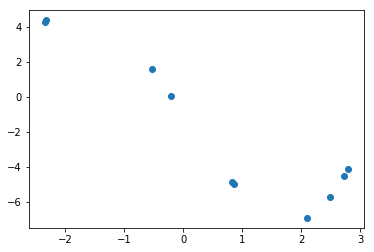

In [2]:
dat = np.load("mystery_function_2.npy")    # Loading in the mystery function
x, y = dat[:, 0], dat[:, 1]
# Visualize the mystery function
plt.scatter(x, y)
plt.show()

In [3]:
xi = np.linspace(x.min(), x.max(), num=1000)
fit1 = interp1d(x, y, kind='nearest')    # Interpolation by using the value closes to a new point x

plt.plot(xi, fit1(xi), '-')
plt.scatter(x, y)
plt.show()

In [4]:
fit2 = interp1d(x, y, kind='linear')    # Interpolation by using straight lines

plt.plot(xi, fit2(xi), '-')
plt.scatter(x, y)
plt.show()

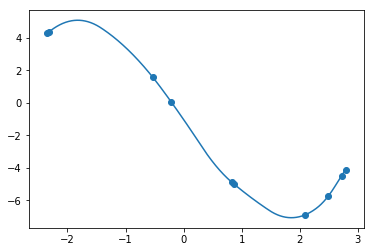

In [5]:
fit3 = interp1d(x, y, kind='quadratic')    # Interpolation by using quadratic curves

plt.plot(xi, fit3(xi), '-')
plt.scatter(x, y)
plt.show()

In [6]:
fit3 = interp1d(x, y, kind='cubic')    # Interpolation using cubic curves

plt.plot(xi, fit3(xi), '-')
plt.scatter(x, y)
plt.show()

## 2D Interpolation

We can interpolate functions of the form $y = f(\pmb{x})$, where $\pmb{x}$ is a vector. $\pmb{x}$ could represent a point in two-dimensional space. We would call this 2D interpolation.

2D interpolation can be used for resizing images. Assume that we are working with grayscale images. A pixel's intensity would be its $y$-value, and its location on the grid its $\pmb{x} = \begin{pmatrix}\xi_1 \\ \xi_2 \end{pmatrix}$ value. (Instead of using direct pixel locations we may normalize coordinates so that they are all numbers between 0 and 1, so that $(0,0)^T$ represents the top-left corner and $(1,1)^T$ the bottom-right corner of the image.) Rescaling requires determining the intensity of pixels not in the original grid; this calls for interpolation.

`griddata()` can be used for this type of interpolation. The following code demonstrates how to enlarge an image of the U.S. capitol building using different interpolation schemes.

In [7]:
from scipy.interpolate import griddata
from PIL import Image
matplotlib.rcParams['figure.figsize'] = (20, 12)

In [9]:
capitol_png = Image.open("USCapitol.png").convert('L')    # Load in the image in grayscale
capitol = np.array(capitol_png)    # Save to a NumPy array, with intensity stored in the array and coordinates of the
                                   # array's entries serving as the pixels' coordinates
capitol.shape

(574, 800)

In [10]:
capitol[:5, :5]

array([[213, 213, 214, 214, 215],
       [215, 215, 215, 215, 215],
       [217, 216, 216, 215, 215],
       [217, 216, 216, 215, 216],
       [218, 217, 217, 217, 217]], dtype=uint8)

In [11]:
plt.imshow(capitol, cmap="gray")    # A grayscale display of the image; see the aliasing?

In [12]:
plt.imshow(capitol)    # Different color mappings may be more informative

In [13]:
plt.imshow(capitol, cmap="hot")    # Aliasing is even more obvious

In [14]:
def griddata_point_format(arr, normalize=True):
    """Converts grayscale image stored in ndarray arr into a format acceptable for griddata, returning a dict
       If normalize is True, coordinates are on a 0-1 scale"""
    
    shape = arr.shape
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    coord_mat = np.transpose([np.tile(x, shape[1]), np.repeat(y, shape[0])])    # Construct a matrix of coordinates
    values = arr[coord_mat[:, 0], coord_mat[:, 1]]    # Construct a 1D array containing the intensity values of the image
                                                      # at the given coordinates
    if normalize:
        # All coordinates will be between 0 and 1
        coord_mat = np.array(coord_mat, dtype=np.float64)
        coord_mat[:, 0] = coord_mat[:, 0] / shape[0]    # Note that 1 is not actually attained; that's fine
        coord_mat[:, 1] = coord_mat[:, 1] / shape[1]
        
    return {"points": coord_mat, "values": values}

def interp_points(length, width, normalize=True):
    """Gets two NumPy arrays corresponding to the points where interpolation should occur"""
    
    grid_x, grid_y = np.mgrid[0:length, 0:width]
    if normalize:
        # This option should be used if normalize is True in griddata_point_format
        # All points will be between 0 and 1
        grid_x = np.array(grid_x, dtype=np.float64)
        grid_y = np.array(grid_y, dtype=np.float64)
        grid_x = grid_x / length
        grid_y = grid_y / width
    
    return (grid_x, grid_y)

test = griddata_point_format(capitol)
test["values"][:5]    # intensities of the first five pixels (bright)

array([213, 215, 217, 217, 218], dtype=uint8)

In [15]:
test["values"][-5:]    # Intensities for last five (dark)

array([1, 1, 2, 3, 4], dtype=uint8)

In [16]:
test["points"][:5, :]    # Location of the first five pixels after normalization (top-left)

array([[0.        , 0.        ],
       [0.00174216, 0.        ],
       [0.00348432, 0.        ],
       [0.00522648, 0.        ],
       [0.00696864, 0.        ]])

In [17]:
test["points"][-5:, :]    # Location of the last five pixels (bottom-right)

array([[0.9912892 , 0.99875   ],
       [0.99303136, 0.99875   ],
       [0.99477352, 0.99875   ],
       [0.99651568, 0.99875   ],
       [0.99825784, 0.99875   ]])

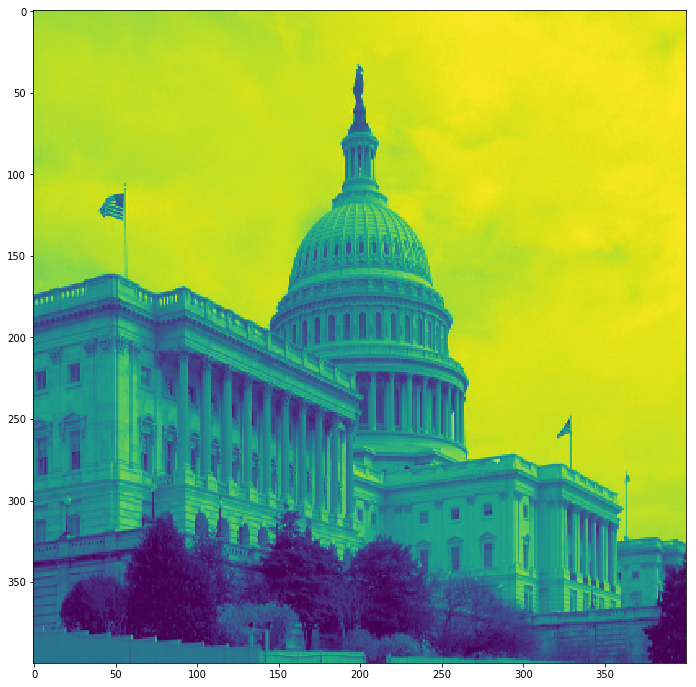

In [18]:
im0 = griddata(xi = interp_points(400, 400), **griddata_point_format(capitol))    # Resize to a 400x400 image

plt.imshow(im0)

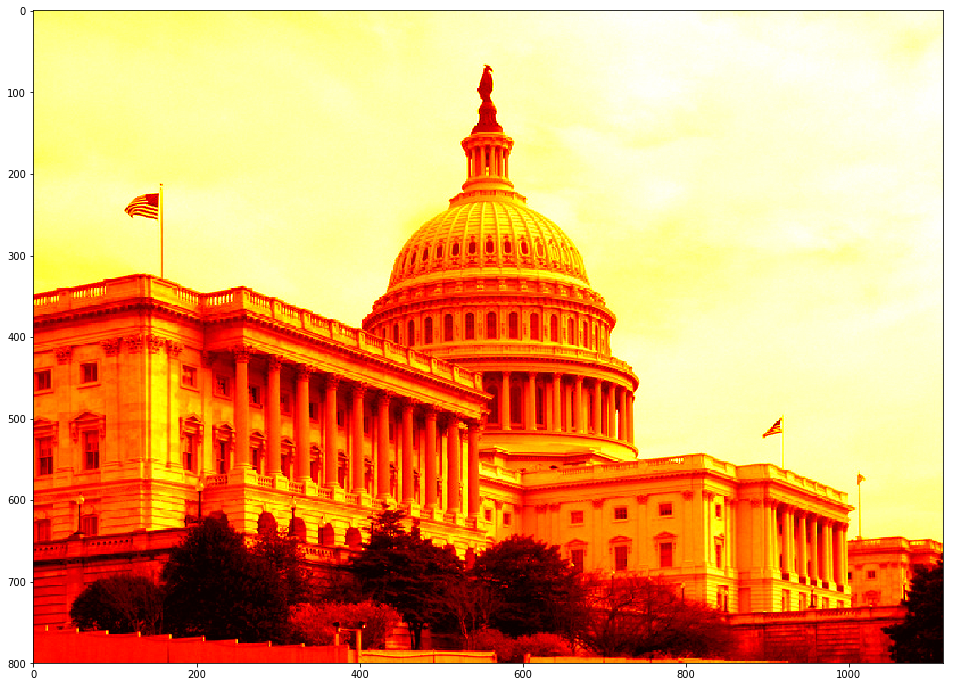

In [19]:
im1 = griddata(xi = interp_points(800, 4 * 279), method="nearest", **griddata_point_format(capitol))    # Quadruple size
plt.imshow(im1, cmap="hot")    # Obvious artifacts due to "nearest" method

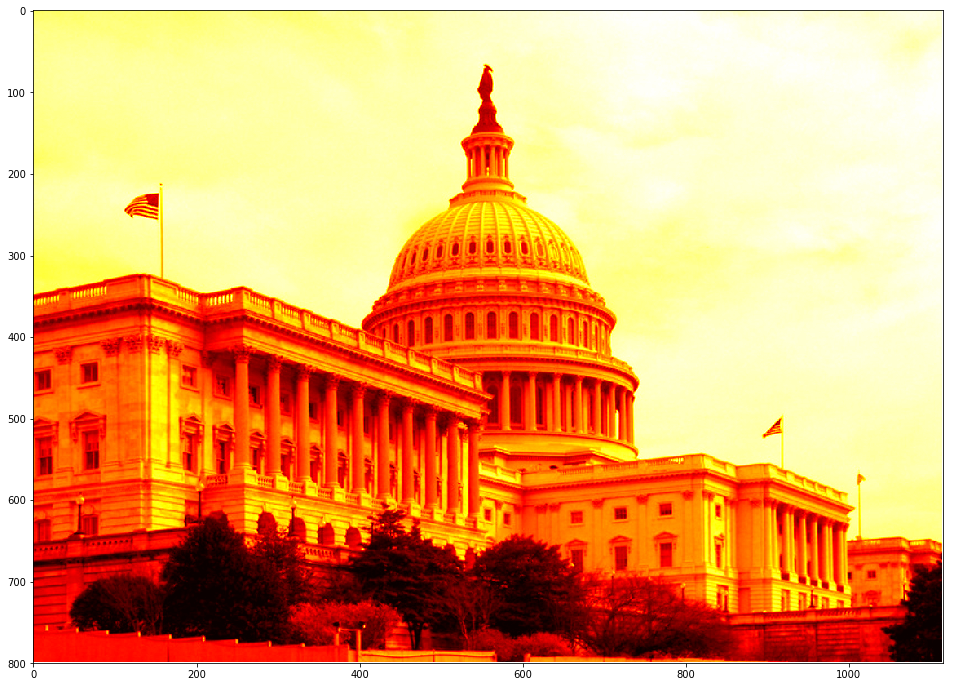

In [20]:
im1 = griddata(xi = interp_points(800, 4 * 279), method="linear", **griddata_point_format(capitol))
plt.imshow(im1, cmap="hot")   # Smoother image

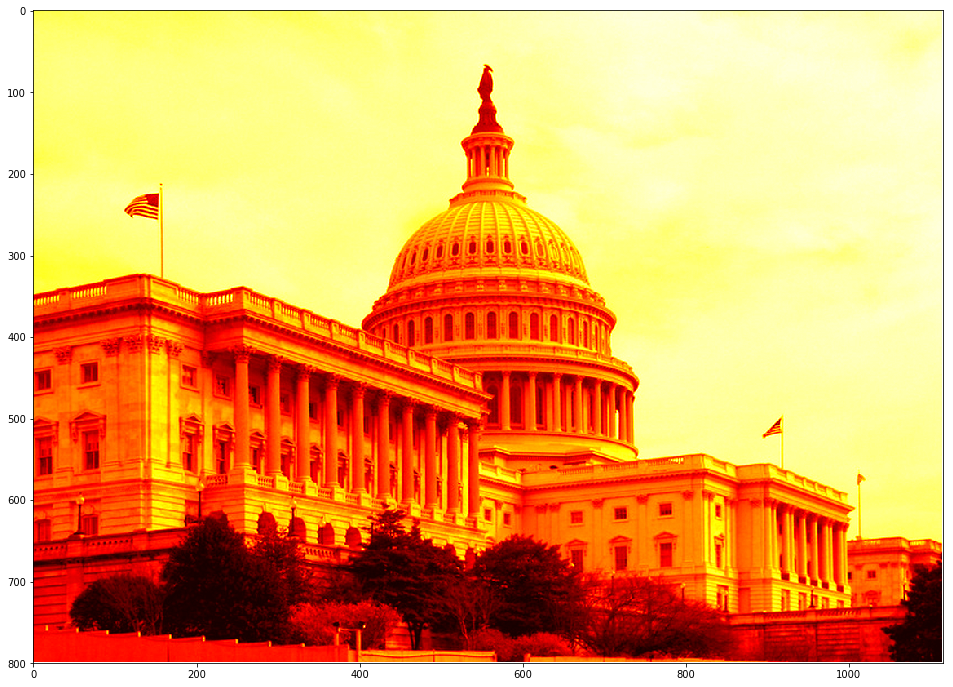

In [21]:
im1 = griddata(xi = interp_points(800, 4 * 279), method="cubic", **griddata_point_format(capitol))
plt.imshow(im1, cmap="hot")    # Arguably the best resizing

Working with color images is similar to working with grayscale images; we view them as three "grayscale" images in one (but intensity is for the colors red, green, and blue each).